In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r'C:\Users\nacho\OneDrive - University of Birmingham\DATA SCIENCE\Summer Project\all_player_data.csv'
df = pd.read_csv(file_path)

C:\Users\nacho\anaconda\envs\notebook-6.1.5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



✅ Best combination:
n_neighbors=5, min_dist=0.0, k=3, silhouette=0.460


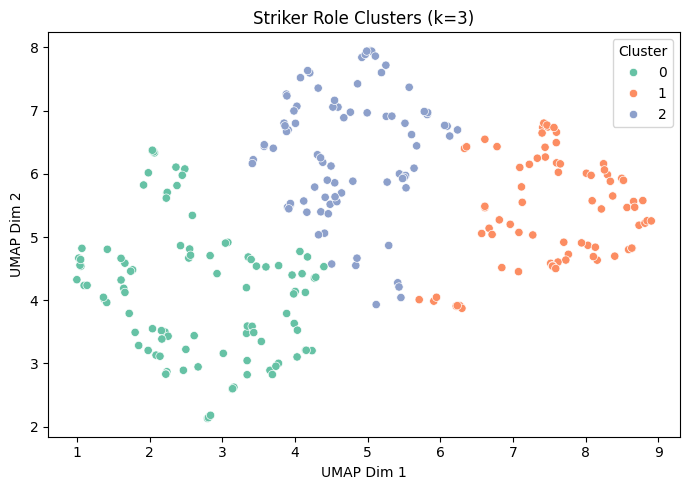

In [3]:
# Target position to analyze
target_position = 'striker'  # <- changed to CB

import warnings
warnings.filterwarnings("ignore")
df["projected_y"] = df["average_position_y"].apply(
    lambda y: 80 - y if y < 40 else y)
    
# Filter for the selected position
group = df[df["position"].str.lower() == target_position.lower()].copy()

# Features tailored for center backs
usable_features = [
    # Passing
    'passes_per_90', 'pass_accuracy', 'progressive_passes_per_90',
    #'progressive_pass_accuracy', 
    #'long_passes_per_90', 
    #'long_pass_accuracy', 
    'key_passes_per_90', 'crosses_per_90', #'cross_accuracy', #'assists_per_90', 
    #'passes_received_per_90',
    
    #shots
    'shots_per_90', 'shots_on_target_per_90', 
    'shot_accuracy', #'goals_per_90', 
    'first_time_shots_per_90', 
    'xg_per_90', 'headers_per_90', 
    'shots_outside_box_per_90',
    
    #dribbles
    'progressive_runs_per_90', 'fouls_won_per_90', 'dribbles_per_90', 'dribble_success_rate',
    'successful_dribbles_per_90', 
    
    # Defense
    'interceptions_per_90', 'blocks_per_90', 'clearances_per_90',
    'dribbled_past_per_90', 'pressures_per_90', 'ball_recoveries_per_90', 

    # Duels / Aerials / Physicality
    'duels_per_90',
    'fouls_made_per_90', 

    # Positioning
    'touches_per_90', 'average_position_x', 'projected_y',
]

# Drop NAs and scale
X = group[usable_features].dropna()
if len(X) < 10:
    print("Not enough valid rows for clustering.")
    exit()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP grid search parameters
n_neighbors_list = [ 5, 10, 15, 30, 50]
min_dist_list = [0.0, 0.05, 0.1, 0.3, 0.5, 0.7]

best_score = -1
best_params = None
best_embedding = None
best_k = None
best_labels = None

# Try all combinations
for n in n_neighbors_list:
    for d in min_dist_list:
        reducer = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2, random_state=42)
        X_umap = reducer.fit_transform(X_scaled)

        for k in range(3, 7):  # try k=2 to k=5
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_umap)
            score = silhouette_score(X_umap, labels)

           # print(f"n_neighbors={n}, min_dist={d}, k={k}, silhouette={score:.3f}")
            
            if score > best_score:
                best_score = score
                best_params = (n, d)
                best_embedding = X_umap
                best_k = k
                best_labels = labels

# Report best
print("\n✅ Best combination:")
print(f"n_neighbors={best_params[0]}, min_dist={best_params[1]}, k={best_k}, silhouette={best_score:.3f}")

# Plot best result
plt.figure(figsize=(7, 5))
sns.scatterplot(x=best_embedding[:, 0], y=best_embedding[:, 1], hue=best_labels, palette='Set2')
plt.title(f"Striker Role Clusters (k={best_k})")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [3]:
# Add cluster labels to the original filtered dataframe (aligned by index)
group = group.loc[X.index].copy()  # ensure index alignment
group['cluster'] = best_labels

# Calculate average stats per cluster
cluster_means = group.groupby('cluster')[usable_features].mean()

# Set option to display all columns
pd.set_option('display.max_columns', None)

print("\n=== Average Stats by Cluster ===")
print(cluster_means)

# (Optional) Reset to default after printing if you want
pd.reset_option('display.max_columns')


=== Average Stats by Cluster ===
         passes_per_90  pass_accuracy  progressive_passes_per_90  \
cluster                                                            
0            19.134500      71.751065                   3.563854   
1            11.893479      67.760764                   2.201361   
2            16.619766      68.655336                   3.140356   

         key_passes_per_90  crosses_per_90  shots_per_90  \
cluster                                                    
0                 0.701291        0.748635      1.947322   
1                 0.406491        0.364745      1.052383   
2                 0.523336        0.426896      1.586140   

         shots_on_target_per_90  shot_accuracy  first_time_shots_per_90  \
cluster                                                                   
0                      0.825728       0.422549                 0.624370   
1                      0.366777       0.352038                 0.333217   
2                      0

In [4]:
for cluster_id, cluster_data in group.groupby('cluster'):
    print(f"\nCluster {cluster_id}:")
    for idx, row in cluster_data.iterrows():
        print(f"Player: {idx}, Name: {row['name']}, ")



Cluster 0:
Player: 3, Name: Borja González Tomás, 
Player: 31, Name: Sergio Ezequiel Araújo, 
Player: 48, Name: Kevin Gameiro, 
Player: 66, Name: Lucas Pérez Martínez, 
Player: 90, Name: Duje Čop, 
Player: 96, Name: Giuseppe Rossi, 
Player: 104, Name: Gerard Moreno Balaguero, 
Player: 177, Name: Rubén Castro Martín, 
Player: 193, Name: Karim Benzema, 
Player: 210, Name: Aritz Aduriz Zubeldia, 
Player: 218, Name: Antoine Griezmann, 
Player: 219, Name: Fernando José Torres Sanz, 
Player: 238, Name: Iago Aspas Juncal, 
Player: 266, Name: Jonathas Cristian de Jesus, 
Player: 283, Name: Adalberto Peñaranda Maestre, 
Player: 303, Name: Adrián López Álvarez, 
Player: 357, Name: Felipe Salvador Caicedo Corozo, 
Player: 369, Name: Luciano Vietto, 
Player: 381, Name: Imanol Agirretxe Arruti, 
Player: 388, Name: Jackson Arley Martínez Valencia, 
Player: 395, Name: Nordin Amrabat, 
Player: 411, Name: Luis Alberto Suárez Díaz, 
Player: 423, Name: Joshua King, 
Player: 434, Name: Jamie Vardy, 
Play

In [5]:
role_map = {
    0: "Complete Forward",
    1: "Poacher",
    2: "Target Man"
}

group = group.loc[X.index].copy()
group["role"] = [role_map[label] for label in best_labels]
group.head()

,player_id,name,minutes,most_played_position,position,passes_per_90,pass_accuracy,progressive_passes_per_90,progressive_pass_accuracy,long_passes_per_90,...,sweeper_claims_per_90,sweeper_clears_per_90,save_percentage,smother_success_rate,collection_success_rate,punch_success_rate,sweeper_success_rate,projected_y,cluster,role
3,6566,Borja González Tomás,3721.57,Center Forward,striker,15.646622,69.397218,2.684351,49.549550,0.580400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.030745,0,Complete Forward
12,27250,Nabil Ghilas,1741.40,Right Center Forward,striker,12.145400,62.127660,2.170667,40.476190,0.723556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.488465,1,Poacher
13,23791,Víctor Casadesús Castaño,1939.07,Right Center Forward,striker,17.962219,67.700258,4.177260,50.000000,1.206764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.107413,1,Poacher
25,6700,Sergio Enrich Ametller,3763.93,Right Center Forward,striker,20.491879,67.911319,3.754055,38.853503,0.549957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.602959,2,Target Man
26,25134,Deyverson Brum Silva Acosta,3267.65,Right Center Forward,striker,17.627347,56.250000,5.288204,30.729167,1.459765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.938561,2,Target Man


In [6]:
final = group.drop(columns = ['cluster', 'projected_y'])
final

,player_id,name,minutes,most_played_position,position,passes_per_90,pass_accuracy,progressive_passes_per_90,progressive_pass_accuracy,long_passes_per_90,...,collections_per_90,punches_per_90,sweeper_claims_per_90,sweeper_clears_per_90,save_percentage,smother_success_rate,collection_success_rate,punch_success_rate,sweeper_success_rate,role
3,6566,Borja González Tomás,3721.57,Center Forward,striker,15.646622,69.397218,2.684351,49.549550,0.580400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Complete Forward
12,27250,Nabil Ghilas,1741.40,Right Center Forward,striker,12.145400,62.127660,2.170667,40.476190,0.723556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Poacher
13,23791,Víctor Casadesús Castaño,1939.07,Right Center Forward,striker,17.962219,67.700258,4.177260,50.000000,1.206764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Poacher
25,6700,Sergio Enrich Ametller,3763.93,Right Center Forward,striker,20.491879,67.911319,3.754055,38.853503,0.549957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Target Man
26,25134,Deyverson Brum Silva Acosta,3267.65,Right Center Forward,striker,17.627347,56.250000,5.288204,30.729167,1.459765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Target Man
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,15796,Babacar Gueye,1062.05,Center Forward,striker,15.338261,74.585635,2.203286,38.461538,0.593192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Poacher
1984,401542,Goran Karanović,830.58,Center Forward,striker,8.343567,72.727273,1.191938,72.727273,0.216716,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Poacher
1989,29133,Brayan Andrés Perea Vargas,972.25,Center Forward,striker,12.219079,68.181818,1.481101,6.250000,0.092569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Poacher
1993,3357,Baptiste Guillaume,972.55,Center Forward,striker,11.845149,57.812500,3.053828,39.393939,0.092540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Poacher


In [8]:
final.to_csv('st_roles.csv', index=False)